<a href="https://colab.research.google.com/github/Lyra7417/Anomaly_Detection/blob/master/GANomaly_tensorflow_ipynb%EF%BC%88%E5%89%AF%E6%9C%AC%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
class Options(object):
  pass

def get_config(is_train):
  opts = Options()
  if is_train:
    opts.batch_size = 300
    opts.isize = 32
    opts.lr = 1e-4
    opts.iteration = 15    
    opts.ckpt_dir = "ckpt"
    opts.z_size = 100
    opts.image_channel=1    
    opts.dis_filter=64
    opts.gen_filter=64
    opts.n_extra_layers=0
    opts.test_batch_size = 300
  else:
    opts.batch_size = 5
    opts.im_size = [128, 128]

    opts.result_dir = "result"
    opts.ckpt_dir = "ckpt"

  return opts

In [2]:
!pip install tensorflow-gpu==1.15

In [3]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [4]:
from __future__ import print_function
from tensorflow.python.keras.layers import Input, Reshape, Dense, Dropout, MaxPooling2D, Conv2D, Flatten
from tensorflow.python.keras.layers import Conv2DTranspose
from tensorflow.python.keras.layers import LeakyReLU
from tensorflow.python.keras.layers import Activation
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import initializers
import numpy as np
from tqdm import tqdm
import cv2
import math
from keras.utils. generic_utils import Progbar
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

''' calculate the auc value for lables and scores'''
def roc(labels, scores, saveto=None):
    """Compute ROC curve and ROC area for each class"""
    roc_auc = dict()
    # True/False Positive Rates.
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    return roc_auc

'''resize the images in batches'''
def batch_resize(imgs, size):
    img_out = np.empty([imgs.shape[0], size[0], size[1]])
    for i in range(imgs.shape[0]):
        img_out[i] = cv2.resize(imgs[i], size, interpolation=cv2.INTER_CUBIC)
    return img_out

''' type-1 loss and type2 loss'''
def l1_loss(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true))

def l2_loss(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

def bce_loss(y_pred,y_true):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,
                                                                  logits=y_pred))
#    return -tf.reduce_mean(y_true * tf.log(y_pred)+(1-y_true)* tf.log(1-y_pred))

'''Tensorflow based batch normalizatioin'''
def batch_norm(x, name, momentum=0.9, epsilon=1e-5, is_train=True):
  return tf.contrib.layers.batch_norm(x, 
    decay=momentum,
    updates_collections=None,
    epsilon=epsilon,
    scale=True,
    is_training=is_train, 
    scope=name)


def Encoder(inputs, opts, istrain=True, name='e1'):
    assert opts.isize % 16 == 0, "isize has to be a multiple of 16"

    ''' initial layer'''
    x = Conv2D(opts.gen_filter, (4, 4), strides=2, padding='same', use_bias=False)(inputs)
    x = LeakyReLU(0.2)(x)
    size_now = opts.isize // 2

    ''' Extra layers'''
    for t in range(opts.n_extra_layers):
        x = Conv2D(opts.gen_filter, (3, 3), padding='same', use_bias=False)(x)
        x = batch_norm(x, name+"_bn1_"+str(t), is_train=istrain)
        x = LeakyReLU(0.2)(x)

    channel = opts.gen_filter # channel: default number is 64

    ''' reduction layers'''
    while size_now > 4:
        x = Conv2D(channel*2, (4, 4), strides=2, padding='same', use_bias=False)(x)
        x = batch_norm(x, name+"_bn2_"+str(channel), is_train=istrain)
        x = LeakyReLU(0.2)(x)    
        channel = channel*2
        size_now = size_now // 2      

    # state size. channel x 4 x 4        

    ''' final layer, resize the layer to channel X 1 X 1'''
    output = Conv2D(opts.z_size, (4, 4), padding='valid', use_bias=False)(x)

    return output


def Decoder(inputs, opts,istrain=True):
    assert opts.isize % 16 == 0, "isize has to be a multiple of 16"

    cngf, tisize = opts.dis_filter // 2, 4

    while tisize != opts.isize:
        cngf = cngf * 2  # after loop, cngf reaches to 256
        tisize = tisize * 2

    '''z is input, and first deconvolution layer to size channel * 4 * 4'''
    x = Conv2DTranspose(cngf, (4, 4), padding='valid', use_bias=False )(inputs)
    x = batch_norm(x, "bn1", is_train=istrain)
    x = Activation('relu')(x)   

    '''size increaing layers '''
    size_now = 4

    while size_now < opts.isize // 2:
        x = Conv2DTranspose(cngf//2, (4, 4),strides=2, padding='same', use_bias=False )(x)
        x = batch_norm(x, "bn2_"+str(size_now), is_train=istrain)
        x = Activation('relu')(x)      
        cngf = cngf // 2
        size_now = size_now*2

    '''extral layers, keep the channel and size of the layers same'''
    for t in range(opts.n_extra_layers):
        x = Conv2DTranspose(cngf, (3, 3), padding='same', use_bias=False )(x)
        x = batch_norm(x, "bn3_"+str(t), is_train=istrain)
        x = Activation('relu')(x)   

    ''' final layer, expand the size with 2 and channel of n_output_channel'''
    x = Conv2DTranspose(opts.image_channel, (4, 4),strides=2, padding='same', use_bias=False )(x)
    x = Activation('tanh')(x)       

    return x


'''generator is the encoder->decoder->encoder structure'''
def generator(inputs, opts, istrain=True):
    with tf.variable_scope('gen_'):
        z = Encoder(inputs, opts, istrain=istrain, name='e1')
        x_star = Decoder(z, opts, istrain=istrain)
        z_star = Encoder(x_star, opts, istrain=istrain, name='e2')
    return x_star, z, z_star


'''discriminator is the same as discriminator from DCGAN'''
def discriminator(inputs, opts, reuse=False, istrain=True, name='d1'):
    with tf.variable_scope('dis_', reuse=reuse):

        ''' initial layer'''
        x = Conv2D(opts.gen_filter, (4, 4), strides=2, padding='same', use_bias=False)(inputs)
        x = LeakyReLU(0.2)(x)
        size_now = opts.isize // 2

        ''' Extra layers'''
        for t in range(opts.n_extra_layers):
            x = Conv2D(opts.gen_filter, (3, 3), padding='same', use_bias=False)(x)
            x = batch_norm(x, name+"_bn1_"+str(t), is_train=istrain)
            x = LeakyReLU(0.2)(x)
    
        channel = opts.gen_filter # channel: default number is 64

        ''' reduction layers'''
        while size_now > 4:
            x = Conv2D(channel*2, (4, 4), strides=2, padding='same', use_bias=False)(x)
            x = batch_norm(x, name+"_bn2_"+str(channel), is_train=istrain)
            x = LeakyReLU(0.2)(x)    
            channel = channel*2
            size_now = size_now // 2

        feature = x

        # state size. channel x 4 x 4        


        x = Conv2D(1, (4, 4), padding='valid', use_bias=False)(x)
        x = Flatten()(x)
        classifier = Dense(1)(x)

        return feature, classifier
             

'''discriminator and generator together class'''
class Ganormal(object):
    def __init__(self, sess, opts):                  
       self.sess = sess
       self.is_train = tf.placeholder(tf.bool)
       self.imsize = opts.isize
       self.im_shape = [opts.batch_size, opts.isize, opts.isize, 1]
       self.img_input = tf.placeholder(tf.float32, self.im_shape)
       self.opts = opts

       '''0 create model'''   
       with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
           self.img_gen, self.latent_z, self.latent_z_gen = generator(self.img_input, self.opts, self.is_train)
           self.feature_fake, self.label_fake = discriminator(self.img_gen, self.opts,False, self.is_train)
           self.feature_real, self.label_real = discriminator(self.img_input,self.opts,True, self.is_train)

       self.t_vars = tf.trainable_variables()
       self.d_vars = [var for var in self.t_vars if 'dis_' in var.name]
       self.g_vars = [var for var in self.t_vars if 'gen_' in var.name]

       '''1 create losses'''
       self.adv_loss = l2_loss(self.feature_fake,self.feature_real )
       self.context_loss = l1_loss(self.img_input, self.img_gen)
       self.encoder_loss = l2_loss(self.latent_z, self.latent_z_gen)
       self.generator_loss = 0.5*self.adv_loss +50*self.context_loss + 1*self.encoder_loss

       '''dis loss: real label reach to 1 and fake label reach to 0'''
       self.real_loss = bce_loss(self.label_real, tf.ones_like(self.label_real)) # real reach to 1
       self.fake_loss = bce_loss(self.label_fake, tf.zeros_like(self.label_fake))
       self.feature_loss = self.real_loss + self.fake_loss #-l2_loss(self.feature_fake, self.feature_real)#
       self.discriminator_loss = self.feature_loss

       '''2 optimize the loss, learning rate and beta1 is from Original code of Pytorch '''
       update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
       with tf.control_dependencies(update_ops):
           with tf.variable_scope(tf.get_variable_scope(), reuse=None):
               self.gen_train_op = tf.train.AdamOptimizer(
                   learning_rate=2e-3,beta1=0.5,beta2=0.999).minimize(self.generator_loss,var_list=self.g_vars)
               self.dis_train_op = tf.train.AdamOptimizer(
                   learning_rate=2e-3,beta1=0.5,beta2=0.999).minimize(self.discriminator_loss,var_list=self.d_vars)

       '''3 save the model '''    
       self.saver = tf.train.Saver()

       '''4 initialization'''
       self.sess.run(tf.global_variables_initializer())

    ''' generator training in keras style'''
    def gen_fit(self, batch_x):    
        _, loss,al,cl,el  = self.sess.run([self.gen_train_op, 
                                  self.generator_loss,
                                  self.adv_loss,
                                  self.context_loss,
                                  self.encoder_loss], 
                               {self.img_input:batch_x,self.is_train: True,})
        return loss,al,cl,el

    

    ''' discriminator training in keras style'''
    def dis_fit(self, batch_x):     
        _, loss,dis_real_loss, dis_fake_loss  = self.sess.run([self.dis_train_op, 
                                  self.discriminator_loss,
                                  self.real_loss,
                                  self.fake_loss], 
                              {self.img_input:batch_x,self.is_train: True,})
        return loss, dis_real_loss, dis_fake_loss

    ''' train the model in dis and gen'''
    def train(self, batch_x):
        gen_loss,al,cl,el = self.gen_fit(batch_x)
        _, dis_real_loss, dis_fake_loss  = self.dis_fit(batch_x)

        # If D loss is zero, then re-initialize netD
        if dis_real_loss < 1e-5 or dis_fake_loss < 1e-5:    
            init_op = tf.variables_initializer(self.d_vars)
            self.sess.run(init_op)
#            print('reinitialize')
        return gen_loss, al,dis_real_loss,dis_fake_loss

    def evaluate(self, whole_x, whole_y):
        bs = self.opts.test_batch_size
        labels_out, scores_out = [], []     
        
        index = 1
        for index in range(int(whole_x.shape[0] / bs)):
            batch_x = whole_x[index*bs:(index+1)*bs]
            batch_y = whole_y[index*bs:(index+1)*bs]
            latent_loss, latent_gen_loss = self.sess.run([self.latent_z, 
                                  self.latent_z_gen], 
                                 {self.img_input:batch_x,self.is_train: False,})

            latent_error = np.mean(abs(latent_loss - latent_gen_loss), axis=-1) 
            latent_error = np.reshape(latent_error, [-1])
            scores_out = np.append(scores_out, latent_error)
            labels_out = np.append(labels_out, batch_y)

            '''Scale scores vector between [0, 1]'''
            scores_out = (scores_out - scores_out.min())/(scores_out.max()-scores_out.min())
  
        '''calculate the roc value'''
        auc_out = roc(labels_out, scores_out)
        return scores_out, labels_out, auc_out


    def save(self, dir_path):
        self.saver.save(self.sess, dir_path+"/model.ckpt")

    '''show the generated images'''
    def show(self,single_x):
        generated_img = self.sess.run(self.img_gen, {self.img_input:single_x, self.is_train:False})
        
        fig = plt.figure()
        ax1, ax2 = fig.subplots(1, 2, sharey=True)
        ax1.imshow(generated_img[0,:,:,0],cmap='gray')
        ax1.set_xticks([])
        ax1.set_yticks([])

        ax2.imshow(single_x[0,:,:,0],cmap='gray')
        ax2.set_xticks([])
        ax2.set_yticks([])  
        plt.show()

        return generated_img[0,:,:,0], single_x[0,:,:,0]

if __name__ == "__main__":  
    opts = get_config(is_train=True)      
    inputs = tf.placeholder(tf.float32, [None, 32, 32, 1])       
#    gen_test,z_test,z_star_test = generator(inputs, opts, istrain=True)
    feature_test, dis_test = discriminator(inputs, opts,tf.AUTO_REUSE,True)
#    print(gen_test)
    print(feature_test, dis_test)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Tensor("dis_/leaky_re_lu_2/LeakyRelu:0", shape=(?, 4, 4, 256), dtype=float32) Tensor("dis_/dense/BiasAdd:0", shape=(?, 1), dtype=float32)


train shape: (54042, 32, 32, 1)
test shape: (10000, 32, 32, 1)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100%|██████████| 180/180 [00:18<00:00,  9.88it/s]


iter      1 :19.5691 a:0.8625 c 0.0003 e0.0002


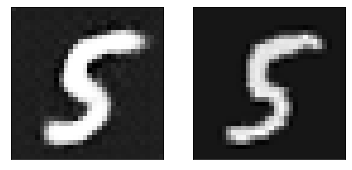

  1%|          | 2/180 [00:00<00:12, 13.84it/s]

iter      1 :AUC 0.885055132207069


100%|██████████| 180/180 [00:13<00:00, 13.47it/s]


iter      2 :13.2534 a:0.8647 c 0.0001 e0.0000


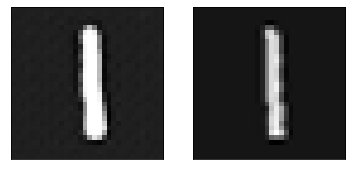

  1%|          | 2/180 [00:00<00:13, 13.32it/s]

iter      2 :AUC 0.9105815208192863


100%|██████████| 180/180 [00:14<00:00, 12.75it/s]


iter      3 :12.3305 a:0.9048 c 0.0005 e0.0009


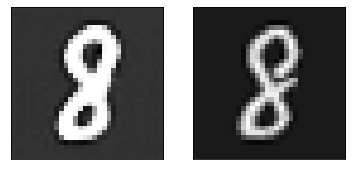

  1%|          | 2/180 [00:00<00:13, 13.63it/s]

iter      3 :AUC 0.840053612028669


100%|██████████| 180/180 [00:13<00:00, 13.53it/s]


iter      4 :11.9733 a:0.9132 c 0.0001 e0.0002


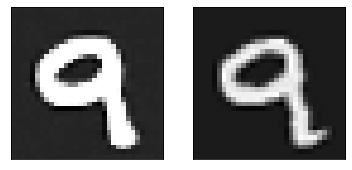

iter      4 :AUC 0.8722558467404699


100%|██████████| 180/180 [00:13<00:00, 13.54it/s]


iter      5 :11.7524 a:0.9159 c 0.0001 e0.0001


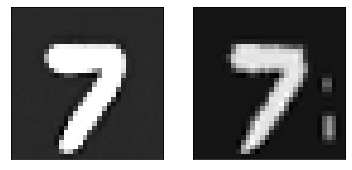

  1%|          | 2/180 [00:00<00:13, 13.44it/s]

iter      5 :AUC 0.8534723110048252


100%|██████████| 180/180 [00:13<00:00, 13.61it/s]


iter      6 :11.5879 a:0.9199 c 0.0000 e0.0001


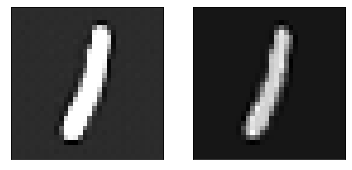

  1%|          | 2/180 [00:00<00:13, 13.56it/s]

iter      6 :AUC 0.8484570987596203


100%|██████████| 180/180 [00:13<00:00, 13.53it/s]


iter      7 :11.4865 a:0.9229 c 0.0000 e0.0000


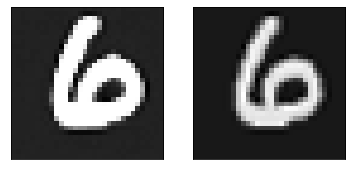

  1%|          | 2/180 [00:00<00:13, 13.66it/s]

iter      7 :AUC 0.8318543941084251


100%|██████████| 180/180 [00:13<00:00, 13.61it/s]


iter      8 :11.4035 a:0.9239 c 0.0000 e0.0000


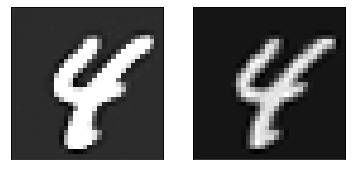

iter      8 :AUC 0.8254149712630674


100%|██████████| 180/180 [00:13<00:00, 13.59it/s]


iter      9 :11.3255 a:0.9264 c 0.0000 e0.0000


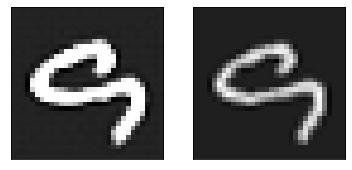

  1%|          | 2/180 [00:00<00:13, 13.64it/s]

iter      9 :AUC 0.8223232994951862


100%|██████████| 180/180 [00:14<00:00, 12.81it/s]

iter     10 :11.2412 a:0.8557 c 0.0002 e0.0001


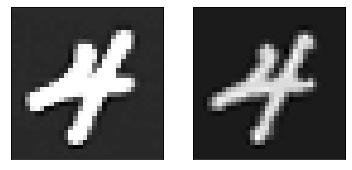

  1%|          | 2/180 [00:00<00:12, 13.74it/s]

iter     10 :AUC 0.8086982945261134


100%|██████████| 180/180 [00:13<00:00, 13.59it/s]


iter     11 :11.1929 a:0.8643 c 0.0001 e0.0000


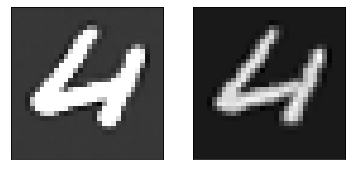

  1%|          | 2/180 [00:00<00:12, 13.90it/s]

iter     11 :AUC 0.8269547506593589


100%|██████████| 180/180 [00:13<00:00, 13.59it/s]


iter     12 :11.1533 a:0.8699 c 0.0000 e0.0000


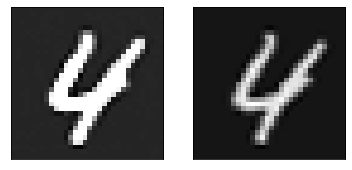

iter     12 :AUC 0.7839490083382418


100%|██████████| 180/180 [00:13<00:00, 13.47it/s]


iter     13 :11.1181 a:0.8726 c 0.0000 e0.0000


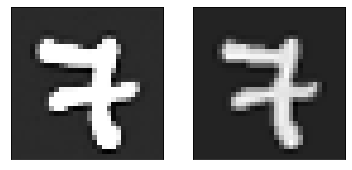

  1%|          | 2/180 [00:00<00:13, 13.49it/s]

iter     13 :AUC 0.7759784503562371


100%|██████████| 180/180 [00:13<00:00, 13.08it/s]

iter     14 :11.0732 a:0.8240 c 0.0000 e0.0000


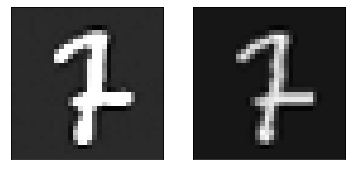

  0%|          | 0/180 [00:00<?, ?it/s]

iter     14 :AUC 0.8085051476290888


100%|██████████| 180/180 [00:14<00:00, 12.02it/s]

iter     15 :11.0262 a:0.8340 c 0.0001 e0.0001


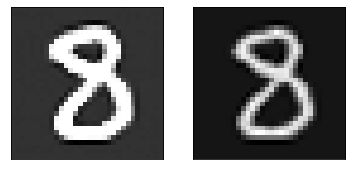

iter     15 :AUC 0.8143885849082679


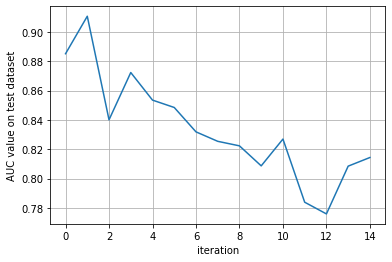

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import tensorflow as tf
from tqdm import tqdm


if __name__ == "__main__":  
    ''' 0. prepare mnist data '''
    anomaly = 2
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    '''normalized the dataset'''
    x_train = (x_train.astype(np.float32) / 255.0 - 0.1307) / 0.3081
    x_test = (x_test.astype(np.float32) / 255.0 - 0.1307) / 0.3081
   

    ''' training takes only numbers without n, here n default is 2, because number 2
        shows the best performance in the manuscript
        and test takes every numbers. and set label-2 class as 1, other sest is to 0.
        resize the images into 32*32 size in order to fit the model input
    '''
    x_train = x_train[y_train != anomaly] 
    x_train = batch_resize(x_train,(32,32)) 
    x_test = batch_resize(x_test,(32,32))
    y_test = 1*(y_test==anomaly)

    '''add one new axis to fit the model input'''
    x_train = x_train[:,:,:,None]
    x_test = x_test[:,:,:,None]

    print ('train shape:', x_train.shape)
    print ('test shape:', x_test.shape)
    
    '''1. train model and evaluate on test data by AUC '''
    sess = tf.Session()   
    opts = get_config(is_train=True)    
    model = Ganormal(sess, opts)

    ''' 
    start training
    '''    
    auc_all = []

    for i in range(opts.iteration):
        loss_train_all = []
        loss_test_all = []
        real_losses = []
        fake_losses = []
        enco_losses = []

        '''shuffle data in each epoch'''
        permutated_indexes = np.random.permutation(x_train.shape[0])

        '''decay the learning rate. we don't do that in tensorflow way because it is more easier to fine-tuning'''
        for index in tqdm(range(int(x_train.shape[0] / opts.batch_size))):
            batch_indexes = permutated_indexes[index*opts.batch_size:(index+1)*opts.batch_size]
            batch_x = x_train[batch_indexes]
            loss, al,cl,el = model.train(batch_x)
            loss_train_all.append(loss)
            real_losses.append(al)
            fake_losses.append(cl)
            enco_losses.append(el)

        print("iter {:>6d} :{:.4f} a:{:.4f} c {:.4f} e{:.4f}".format(i+1, np.mean(loss_train_all),
                                                  np.mean(al),
                                                  np.mean(cl),
                                                  np.mean(el)))

        g1, r1 = model.show(batch_x)    

        ''' evaluate the model with test dataset and calculate the AUC value'''
        if (i+1) % 1 == 0:
            scores_out, labels_out, auc_out = model.evaluate(x_test, y_test)

            print("iter {:>6d} :AUC {}".format(i+1, auc_out))
          
            auc_all.append(auc_out)

        '''save the model'''
        if (i+1) % 4 ==0:
            model.save(opts.ckpt_dir)
       
    '''visualization'''
    plt.plot(auc_all)
    plt.xlabel('iteration')
    plt.ylabel('AUC value on test dataset')
    plt.grid(True)
    plt.show()